| 지표 | 정의 (전체 데이터 기준) |
| --- | --- |
| **Recency** | `현재 step - 마지막 거래 step` |
| **Frequency** | 전체 거래 횟수 |
| **Monetary** | 전체 거래 금액 합계 / 평균 |

[paysim.db] 연결 및 데이터 정합성 맞추기...
Current Step: 806, Period Start: 63
Executing SQL Query...

Data Loaded! Rows: 99999 (Customers)
      nameOrig  last_step  Frequency  MonetarySum  MonetaryAvg  Recency
0  C1000009135         19          0         0.00         0.00      787
1  C1000015836        163          1     77027.49     77027.49      643
2  C1000018718        138          1     32100.16     32100.16      668
3   C100006663         15          0         0.00         0.00      791
4  C1000071455         42          0         0.00         0.00      764

=== RFM Summary Stats ===
     metric  count       mean   median        std        p90
    Recency  99999    558.699   555.00    143.343    770.000
  Frequency  99999      0.980     1.00      0.755      1.000
MonetarySum  99999 181197.273 43871.60 749712.478 367122.166
MonetaryAvg  99999 156433.569 40664.26 553123.178 333609.584


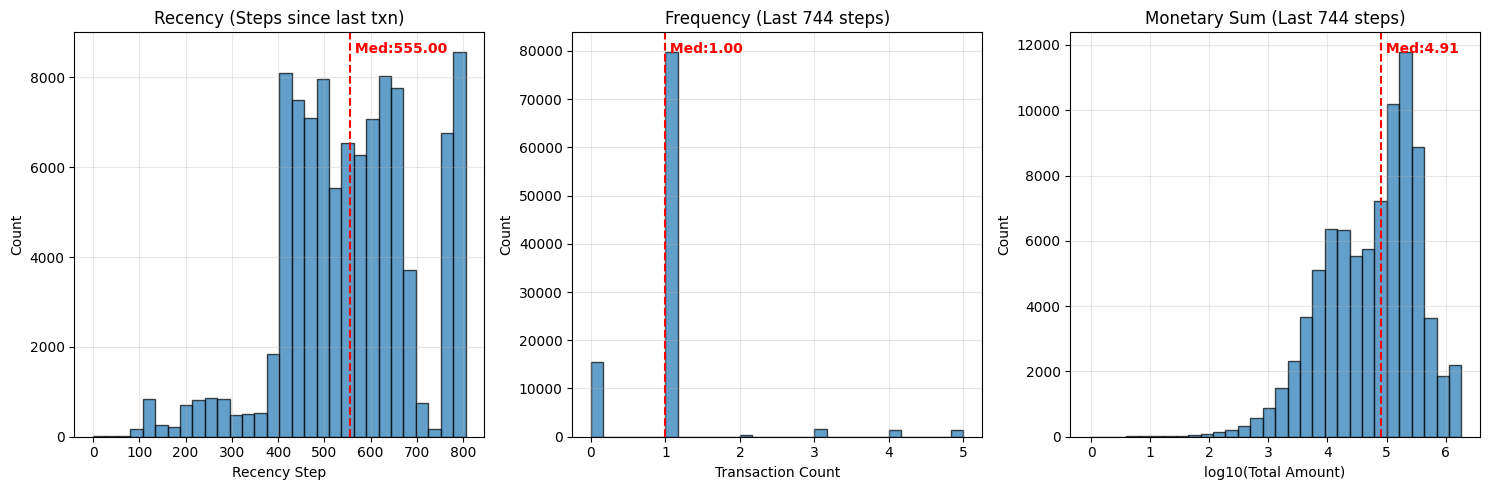


Saved: rfm_sqlite_result.csv


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text

# =========================
# 1) 설정
# =========================
DB_PATH = "paysim.db" 
TABLE   = "PaySim"
period_steps = 744 #과거 데이터 (Step 1 ~ 62)는 제외됨 
clip_pct = 0.99

engine = create_engine(f"sqlite:///{DB_PATH}")

with engine.connect() as conn:
    print(f"[{DB_PATH}] 연결 및 데이터 정합성 맞추기...")

    # [Step 1] 분석 기준 시점(Last Step) 구하기
    # CAST(step AS INTEGER)로 확실하게 정수화
    max_step_query = text(f"SELECT MAX(CAST(step AS INTEGER)) FROM {TABLE}")
    current_step = conn.execute(max_step_query).scalar()
    
    if current_step is None:
        raise ValueError("데이터가 없습니다.")
        
    current_step = int(current_step)
    period_start = current_step - period_steps + 1
    print(f"Current Step: {current_step}, Period Start: {period_start}")

    # [Step 2] RFM 계산 (Python 로직과 100% 일치시키기)
    # Python의 pd.to_numeric(errors='coerce')와 dropna 효과를 내는 쿼리
    print("Executing SQL Query...")
    
    # --파라미터 바인딩(Parameter Binding): :p_start는 이름표임 나중에 실제 변수랑 연결시켜줘야함
    query = text(f"""
        SELECT 
            nameOrig,
            -- 1. Recency용: 조건(CASE WHEN) 없이 전체 기간에서 찾음
            MAX(CAST(step AS INTEGER)) as last_step,
            
            -- Frequency: step을 강제로 정수로 바꾼 뒤 비교
            COUNT(CASE WHEN CAST(step AS INTEGER) >= :p_start THEN 1 END) as Frequency,
            
            -- Monetary: amount를 강제로 실수(Float)로 바꾼 뒤 합산
            -- 데이터가 깨져있으면 0으로 처리되므로 안전함
            COALESCE(SUM(CASE WHEN CAST(step AS INTEGER) >= :p_start THEN CAST(amount AS FLOAT) END), 0) as MonetarySum,
            
            -- MonetaryAvg
            AVG(CASE WHEN CAST(step AS INTEGER) >= :p_start THEN CAST(amount AS FLOAT) END) as MonetaryAvg
        FROM {TABLE}
        WHERE
            -- Python의 dropna()와 같은 역할: 이상한 데이터는 아예 집계에서 뺌
            typeof(step) IN ('integer', 'real') 
            OR (typeof(step) = 'text' AND step GLOB '[0-9]*')
    
        GROUP BY nameOrig
    """)
    
    rfm = pd.read_sql(query, conn, params={"p_start": period_start})

# =========================
# 3) Python 후처리
# =========================
# Recency 계산 (현재 시점 - 마지막 거래 시점)
rfm['Recency'] = current_step - rfm['last_step']

# MonetaryAvg 결측치(거래 없는 경우) 0으로 채우기
rfm['MonetaryAvg'] = rfm['MonetaryAvg'].fillna(0)

print(f"\nData Loaded! Rows: {len(rfm)} (Customers)")
print(rfm.head())

# =========================
# 4) 요약 통계 (Summary Stats)
# =========================
summary = pd.DataFrame({
    'metric': ['Recency','Frequency','MonetarySum','MonetaryAvg'],
    'count':  [rfm['Recency'].notna().sum(),
               rfm['Frequency'].notna().sum(),
               rfm['MonetarySum'].notna().sum(),
               rfm['MonetaryAvg'].notna().sum()],
    'mean':   [rfm['Recency'].mean(),
               rfm['Frequency'].mean(),
               rfm['MonetarySum'].mean(),
               rfm['MonetaryAvg'].mean()],
    'median': [rfm['Recency'].median(),
               rfm['Frequency'].median(),
               rfm['MonetarySum'].median(),
               rfm['MonetaryAvg'].median()],
    'std':    [rfm['Recency'].std(),
               rfm['Frequency'].std(),
               rfm['MonetarySum'].std(),
               rfm['MonetaryAvg'].std()],
    'p90':    [rfm['Recency'].quantile(0.9),
               rfm['Frequency'].quantile(0.9),
               rfm['MonetarySum'].quantile(0.9),
               rfm['MonetaryAvg'].quantile(0.9)]
})
print("\n=== RFM Summary Stats ===")
print(summary.round(3).to_string(index=False))

# =========================
# 5) 시각화 (Visualization)
# =========================
# 시각화 함수 정의
def hist_with_median(ax, data, bins, title, xlabel, clip_at=None, log=False):
    x = data.copy()
    if clip_at is not None:
        cap = x.quantile(clip_at)
        x = x.clip(upper=cap)
    if log:
        # 0 이하 값은 로그 변환 불가하므로 제외
        x = x[x > 0] 
        x = np.log10(x)
        xlabel = f"log10({xlabel})"
    
    x = x.dropna()

    ax.hist(x, bins=bins, edgecolor='black', alpha=0.7)
    
    if len(x) > 0:
        med = x.median()
        ax.axvline(med, color='red', linestyle='--', linewidth=1.5)
        ax.text(med, ax.get_ylim()[1]*0.95, f" Med:{med:.2f}", color='red', fontweight='bold')
        
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Count")
    ax.grid(alpha=0.3)

figsize = (15, 5) # 가로로 긴 형태
fig, axes = plt.subplots(1, 3, figsize=figsize)

# 5-1) Recency
hist_with_median(axes[0],
                 rfm['Recency'],
                 bins=30,
                 title="Recency (Steps since last txn)",
                 xlabel="Recency Step")

# 5-2) Frequency
hist_with_median(axes[1],
                 rfm['Frequency'],
                 bins=30,
                 title=f"Frequency (Last {period_steps} steps)",
                 xlabel="Transaction Count",
                 clip_at=clip_pct)

# 5-3) MonetarySum
hist_with_median(axes[2],
                 rfm['MonetarySum'],
                 bins=30,
                 title=f"Monetary Sum (Last {period_steps} steps)",
                 xlabel="Total Amount",
                 clip_at=clip_pct,
                 log=True)

plt.tight_layout()
plt.show()

# =========================
# 6) 결과 저장
# =========================
# 분석 결과를 CSV로 저장 (필요시)
rfm.to_csv("rfm_sqlite_result.csv", index=False)
print("\nSaved: rfm_sqlite_result.csv")

- paysim데이터 특성 상 극단적인 치우침이 존재하기때문에 평균이 아닌 중위수를 표시함

### 해석

1. Recency Distribution (Full Dataset)
> 대부분의 고객은 약 500~700 step 사이에 마지막 거래를 기록했으며, 거래 시점 기준으로 고객의 최신성을 나타낸 그래프입니다.
> 
> 
> 중앙값(555 step) 기준으로 보았을 때 최근 거래 활동이 활발한 사용자는 비교적 적습니다.
>

2.  Frequency Distribution (Period_step)
> 송신자별 거래 횟수를 나타낸 그래프입니다.
> 
> 
> 대부분의 계정이 단 한 번만 거래를 수행한 것으로 나타나,
> 
> 소수의 반복 거래 계정이 전체 거래 구조를 형성하고 있음을 보여줍니다.
>

3. MonetarySum Distribution (Period_step)
> 송신자별 총 거래 금액(로그 스케일)을 나타낸 그래프입니다.
> 
> 
> 오른쪽으로 갈수록 실제 거래 금액이 커지며,
> 
> 중앙값은 약 10⁴․⁹(약 8만 단위)로 대부분의 사용자는 이 수준의 금액을 거래했습니다.
> 
> 일부 고액 거래 계정으로 인해 분포의 꼬리가 오른쪽으로 길게 늘어납니다.
>



*“오른쪽 꼬리가 길다(right-skewed)”는 값이 큰 일부 관측치들이 평균을 오른쪽으로 끌고 가는 분포”라는 뜻*

*오른쪽 꼬리(long right tail) → 큰 값 쪽으로 길게 늘어난 분포*

*왼쪽 꼬리(long left tail) → 작은 값 쪽으로 길게 늘어난 분포*